In [1]:
import pandas as pd
import numpy as np
import pygmt

In [2]:
class Cpt:
    def __init__(self, cpt):
        cpt = pd.read_csv(cpt, sep='\t', header=None)
        self.cpt_o = cpt.iloc[-3:]
        cpt = cpt[:-3]
        cpt[0] = np.asfarray(cpt[0])
        self.cpt = cpt
    def __call__(self, value):
        if value is None:
            return self.cpt_o.iloc[2, 1]
        idx = np.sum(self.cpt[0] < value) - 1
        if idx < 0:
            return self.cpt_o.iloc[0, 1]
        elif idx + 2 > self.cpt.shape[0]:
            return self.cpt_o.iloc[1, 1]
        else:
            return self.cpt.iloc[idx, 1]

In [3]:
cat = pd.read_csv('./aftershocks.csv')


In [4]:
cat['time'] = pd.to_datetime(cat['time'])
cat = cat[cat.time > pd.to_datetime('2024-12-05T18:44:21')]

In [12]:
cat_on_fault = pd.read_csv('./aftershocks_on_fault.csv')
cat_on_fault['time'] = pd.to_datetime(cat_on_fault['time'])
cat_on_fault = cat_on_fault[cat_on_fault.time > pd.to_datetime('2024-12-05T18:44:21')]

In [ ]:
repeating_cat = pd.read_csv('./repeating_earthquakes.csv')
background = pd.read_csv('./background_seismicity.csv')
mainshock = pd.read_csv('./mainshock.csv')

In [6]:
static_inv = pd.read_csv('./static_inv.csv')
gnss = pd.read_csv('./gnss_data.csv')
static_inv_gnss_syn = pd.read_csv('./static_inv_gnss_syn.csv')
fault_cords = pd.read_csv('./fault_cords.csv')

kinematic_inv = pd.read_csv('./Solucion_strike_98.param', skiprows=10, delim_whitespace=True, header=None)
kinematic_inv.columns = ['lat', 'lon', 'depth', 'slip', 'rake', 'strike', 'dip', 't_rup', 't_ris', 't_fal', 'mo']
kinematic_inv_gnss_syn = pd.read_csv('./kinematic_inv_gnss_syn.csv')

/var/folders/nl/t7s78mr971d9b7jt5ymp69fr0000gr/T/ipykernel_94226/43532691.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  kinematic_inv = pd.read_csv('./Solucion_strike_98.param', skiprows=10, delim_whitespace=True, header=None)


In [7]:
cpt = Cpt('./slip.cpt')

In [8]:
stf = pd.read_csv('./stf.csv')
stf = stf[stf.time <= 21]
stf = pd.concat([stf, pd.DataFrame([[21, 0]], columns=['time', 'Moment_Rate'])])

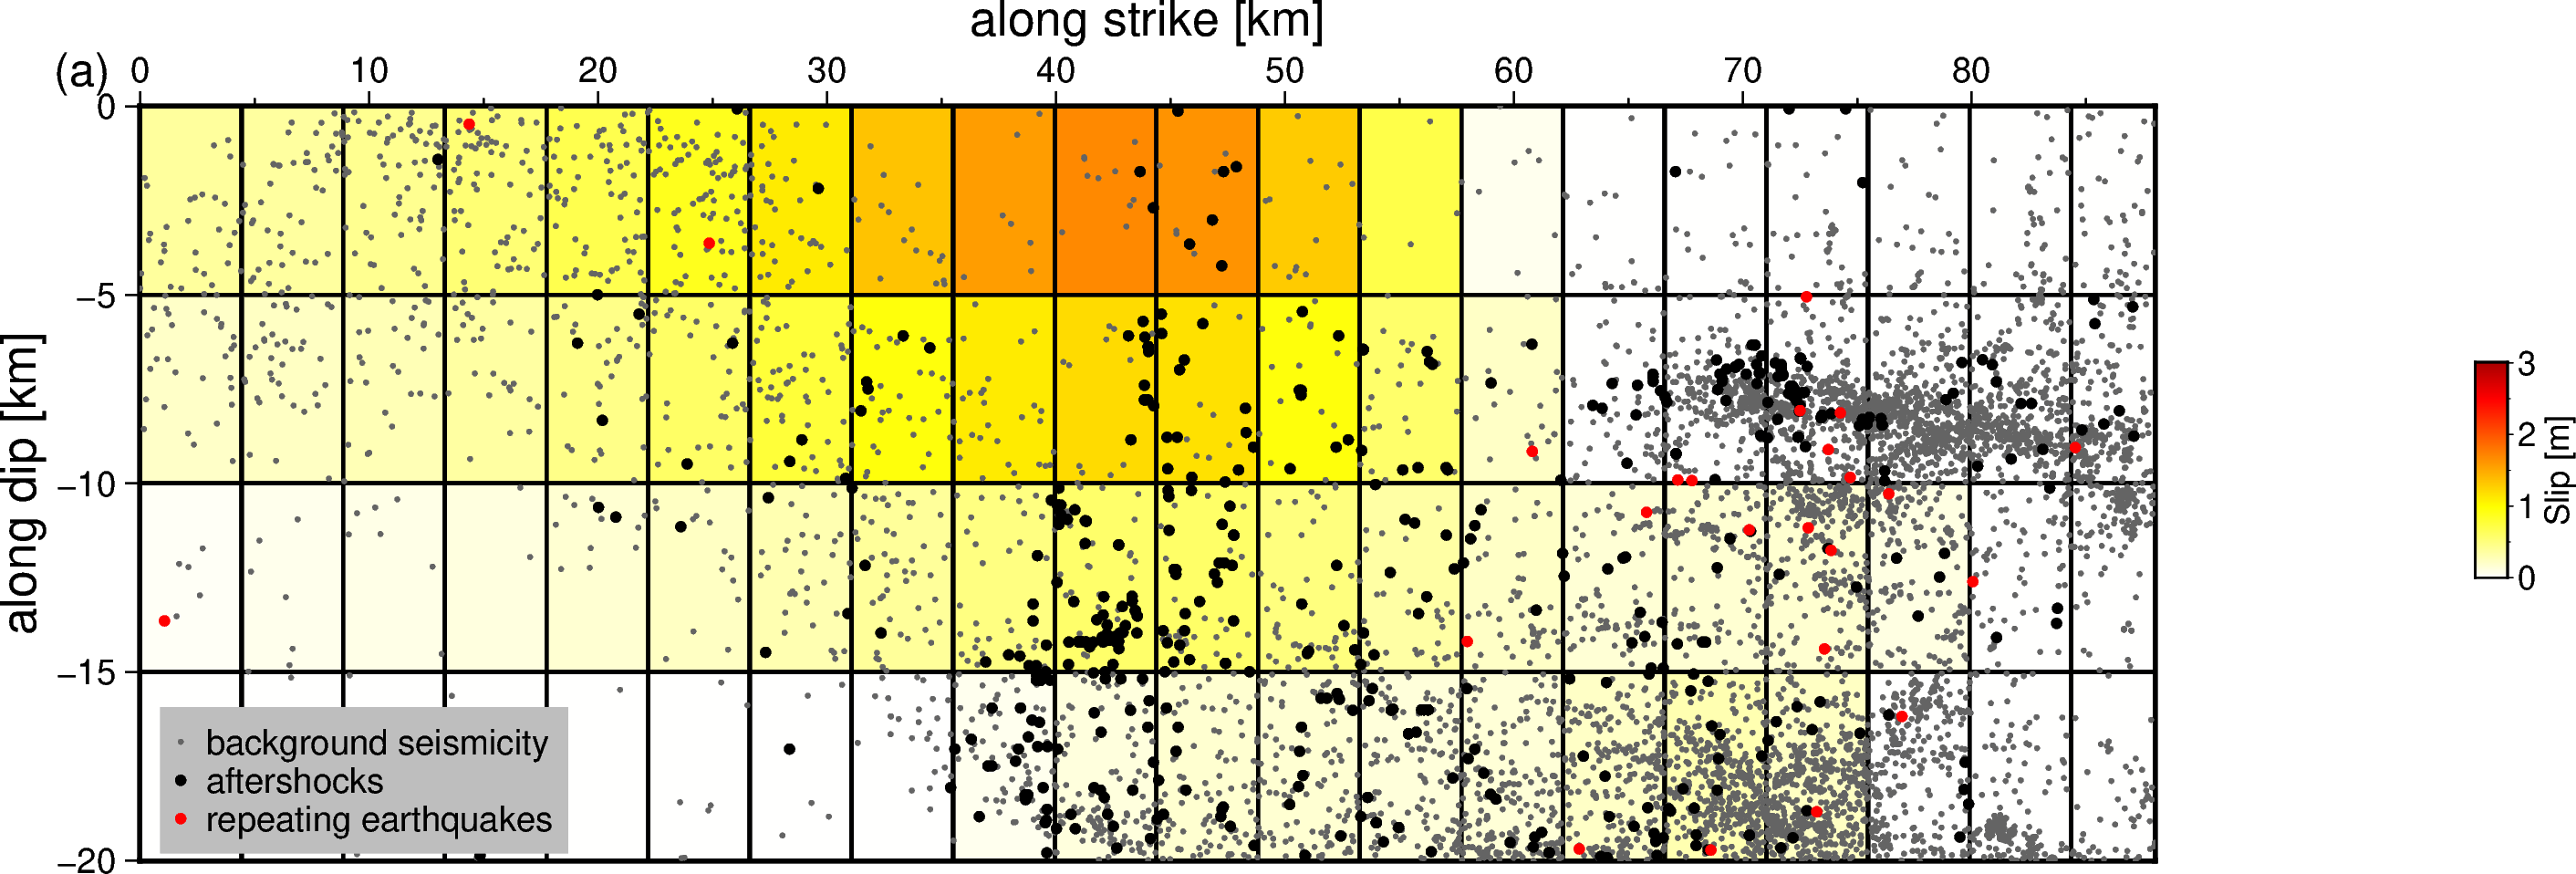

In [11]:


fig = pygmt.Figure()
fig.basemap(projection='X18.7c/7c', region=[0, 88, -20, 0], frame=['WNbr', 'xa10f5+lalong strike [km]', 'ya5+lalong dip [km]'])
for i, row in static_inv.iterrows():
    fig.plot(x=[row.r, row.l, row.l, row.r], y=-np.array([row.t, row.t, row.b, row.b]), pen='1p,black', close=True, fill=cpt(row.slip))
cc = 100
fig.plot(x = background.along_stk_disloc, y=-background.depth, style='c0.05c', fill=f'{cc}/{cc}/{cc}', label='background seismicity')
fig.plot(x = cat.along_stk_disloc, y=-cat.depth, style='c0.10c', fill='black', label='aftershocks')
fig.plot(x = repeating_cat.along_stk_disloc, y=-repeating_cat.depth, style='c0.1c', fill='red', label='repeating earthquakes')


with pygmt.config(FONT_LABEL='24p,Helvetica,black', FONT_ANNOT_PRIMARY='24p,Helvetica,black'):
    fig.colorbar(frame=['xa1f0.5+lSlip [m]', 'ya0.5'], position='g102/-12.5.5+w2c/0.3c', cmap='slip.cpt')
fig.text(position='TL', no_clip=True, text='(a)', font='12p,Helvetica,black', offset='-0.8c/0.5c')
fig.legend(position='n0.01/0.01', box='+ggray')

fig.savefig('./fig2.pdf')

fig.show(width=1200)

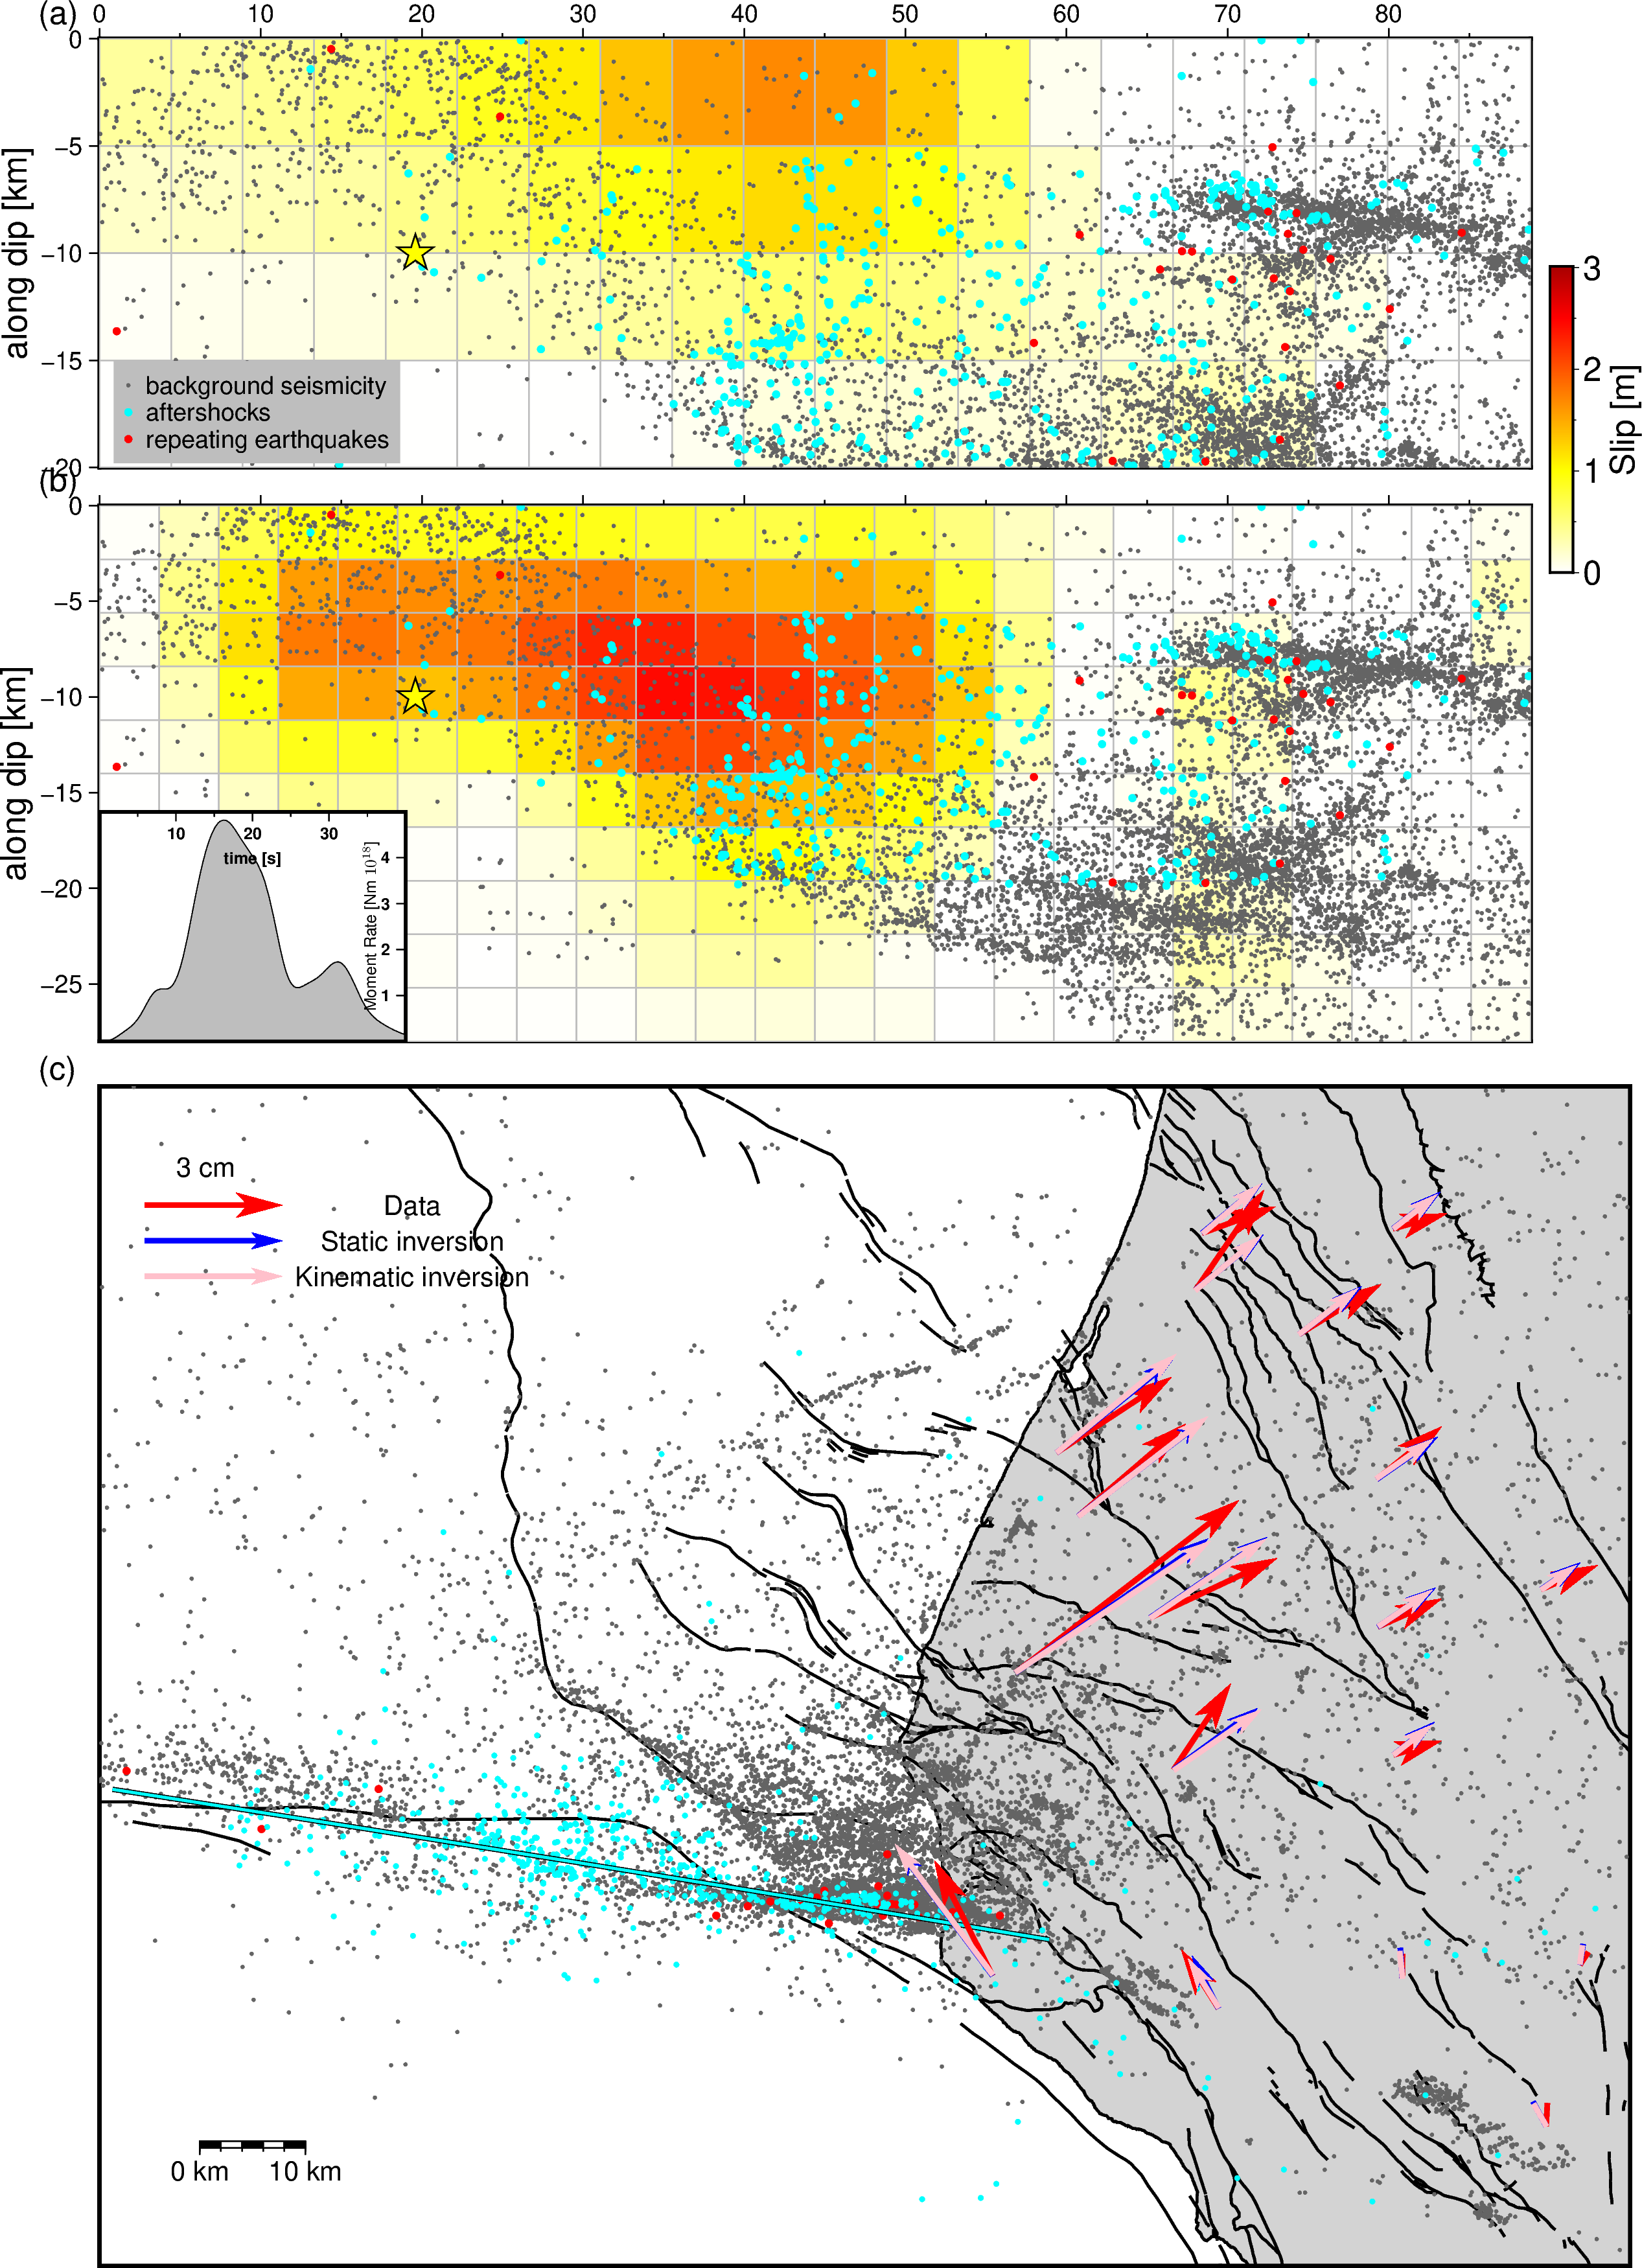

In [23]:
region=[-125.3, -123.6, 40, 41]
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.xx', MAP_FRAME_TYPE='plain')

#### panel c #####

fig.coast(
    frame=['lrtb'],
    projection=f"M20",
    region=region,
    shorelines='1p,black',
    land = 'lightgray'
    
)
fig.plot(
    data='./faults.gmt',
    pen="1p,black",
)
cc = 100
fig.plot(
    x=background.lon,
    y=background.lat,
    style="c0.05c",
    fill=f'{cc}/{cc}/{cc}',
)
fig.plot(
    x=repeating_cat.lon,
    y=repeating_cat.lat,
    style="c0.1c",
    fill='red',
)
fig.plot(
    x=cat.lon,
    y=cat.lat,
    style="c0.07c",
    fill="cyan",
)
spec="e60/0.39+f18"
fig.plot(x=fault_cords.lon, y=fault_cords.lat, pen='1.8p,black', close=True)
fig.plot(x=fault_cords.lon, y=fault_cords.lat, pen='1p,cyan', close=True)

disp = gnss[['id', 'lon', 'lat', 'E', 'N']]
fig.velo(
    data=disp.iloc[:, 1:],
    spec=spec,
    pen="2p,red",
    line=True,
    vector="0.6c+e+gred",
)
fig.velo(
    data=static_inv_gnss_syn[['lon', 'lat', 'E', 'N']],
    spec=spec,
    pen="2p,blue",
    line=True,
    vector="0.4c+e+gblue",
)
fig.velo(
    data=kinematic_inv_gnss_syn[['lon', 'lat', 'E', 'N']],
    spec=spec,
    pen="2p,pink",
    line=True,
    vector="0.4c+e+gpink",
)
size = 0.03
fig.velo(
    data=[[-125.25, 40.87, size, 0]],
    spec=spec,
    pen="2p,blue",
    line=True,
    vector="0.4c+e+gblue",
)
fig.velo(
    data=[[-125.25, 40.84, size, 0]],
    spec=spec,
    pen="2p,pink",
    line=True,
    vector="0.4c+e+gpink",
)
fig.velo(
    data=[[-125.25, 40.9, size, 0]],
    spec=spec,
    pen="2p,red",
    line=True,
    vector="0.6c+e+gred",
)
fig.text(x=-125.25, y=40.9, text='3 cm', font="10p", offset='0.8c/0.5c')
fig.text(x=-125.25, y=40.87, text='Static inversion', font="10p", offset='3.5c/0.0c') 
fig.text(x=-125.25, y=40.84, text='Kinematic inversion', font="10p", offset='3.5c/0.0c') 
fig.text(x=-125.25, y=40.9, text='Data', font="10p", offset='3.5c/0.0c')




fig.basemap(map_scale="n0.1/0.1+w10k+f+u")
fig.text(position='TL', no_clip=True, text='(c)', font='12p,Helvetica,black', offset='-0.8c/0.4c')


### panel b #####
fig.shift_origin(yshift='16c')
fig.basemap(projection='X18.7c/7c', region=[0, 88.8, -28., 0], frame=['Wbnr', 'xa10f5', 'ya5+lalong dip [km]'])
dist_dip = 0
for along_dip in range(10):
    dist_stk = 0
    for  along_stk in range(24):
        subfault = kinematic_inv.iloc[along_dip * 24 + along_stk]
        r = dist_stk
        l = dist_stk + 3.7
        t = dist_dip
        b = dist_dip  - 2.85
        fig.plot(x=[r, l, l, r], y=np.array([t, t, b, b]), pen='0.5p,gray', close=True, fill=cpt(subfault.slip * 1e-2))
        dist_stk += 3.7
    dist_dip -= 2.8
cc = 100
fig.plot(x = background.along_stk_disloc, y=-background.depth, style='c0.05c', fill=f'{cc}/{cc}/{cc}')
fig.plot(x = cat_on_fault.along_stk_disloc, y=-cat_on_fault.depth, style='c0.1c', fill='cyan')
fig.plot(x = repeating_cat.along_stk_disloc, y=-repeating_cat.depth, style='c0.1c', fill='red')
fig.plot(x = mainshock.along_stk_disloc, y=-mainshock.depth, style='a0.5c', fill='yellow', pen='0.5p,black')
fig.text(position='TL', no_clip=True, text='(b)', font='12p,Helvetica,black', offset='-0.8c/0.5c')
with pygmt.config(FONT_LABEL='24p,Helvetica,black', FONT_ANNOT_PRIMARY='24p,Helvetica,black'):
    fig.colorbar(frame=['xa1f0.5+lSlip [m]', 'ya0.5'], position='g90/-3.5+w4c/0.3c', cmap='slip.cpt')
    
### panel b inset ###
fig.shift_origin(yshift='0.0c', xshift='0.0c')
with pygmt.config(FONT_LABEL='8p,Helvetica-Bold,black', FONT_ANNOT_PRIMARY='8p,Helvetica-Bold,black'):
    fig.basemap(projection='X4c/3c', region=[0.0001, 20.9999, 0.001, 5], frame=['tblr+gwhite'])
fig.plot(x=stf.time, y=stf.Moment_Rate / 1e18, pen='0.3p,black', close=True, fill='gray')
with pygmt.config(FONT_LABEL='6p,Helvetica-Bold,black', FONT_ANNOT_PRIMARY='6p,Helvetica-Bold,black', MAP_FRAME_TYPE='inside'):
    fig.basemap(projection='X4c/3c', region=[0.0001, 39.999, 0.001, 5], frame=['lNbE', 'xa10f5+ltime [s]', 'ya1+lMoment Rate [Nm @[10^{18}@[]'])


### panel a #####
fig.shift_origin(yshift='7.5c')
fig.basemap(projection='X18.7c/5.6c', region=[0, 88.8, -20., 0], frame=['WbNr', 'xa10f5', 'ya5+lalong dip [km]'])
for i, row in static_inv.iterrows():
    fig.plot(x=[row.r, row.l, row.l, row.r], y=-np.array([row.t, row.t, row.b, row.b]), pen='0.5p,gray', close=True, fill=cpt(row.slip))
cc = 100
fig.plot(x = background.along_stk_disloc, y=-background.depth, style='c0.05c', fill=f'{cc}/{cc}/{cc}', label='background seismicity')
fig.plot(x = cat_on_fault.along_stk_disloc, y=-cat_on_fault.depth, style='c0.1c', fill='cyan', label='aftershocks')
fig.plot(x = repeating_cat.along_stk_disloc, y=-repeating_cat.depth, style='c0.1c', fill='red', label='repeating earthquakes')
fig.plot(x = mainshock.along_stk_disloc, y=-mainshock.depth, style='a0.5c', fill='yellow', pen='0.5p,black')



fig.text(position='TL', no_clip=True, text='(a)', font='12p,Helvetica,black', offset='-0.8c/0.5c')
fig.legend(position='n0.01/0.01', box='+ggray')



fig.show(width=1200)

In [24]:
7 / 5 * 4

5.6

In [98]:
stf

,Unnamed: 0,time,Moment_Rate
0,0,0.00,0.000000e+00
1,1,0.01,2.496300e+11
2,2,0.02,1.248100e+12
3,3,0.03,3.494100e+12
4,4,0.04,7.486100e+12
...,...,...,...
5627,5627,56.27,0.000000e+00
5628,5628,56.28,0.000000e+00
5629,5629,56.29,0.000000e+00
5630,5630,56.30,0.000000e+00


In [99]:
stf.max()

Unnamed: 0     5.631000e+03
time           5.631000e+01
Moment_Rate    4.818800e+18
dtype: float64

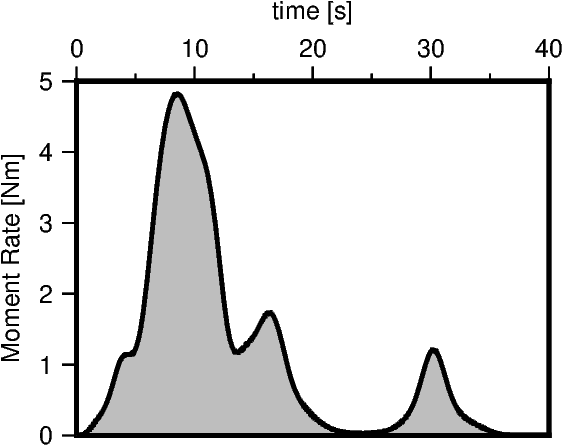

In [109]:
fig = pygmt.Figure()
with pygmt.config(FONT_LABEL='6p,Helvetica,black', FONT_ANNOT_PRIMARY='6p,Helvetica,black'):
    fig.basemap(projection='X4c/3c', region=[0, 40, 0, 5], frame=['WNbr', 'xa10f5+ltime [s]', 'ya1+lMoment Rate [Nm]'])
fig.plot(x=stf.time, y=stf.Moment_Rate / 1e18, pen='1p,black', close=True, fill='gray')


fig.show()